In [1]:
import sys

sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np

In [3]:
#start_date = '2021-01-01'
#end_date = '2021-09-07'

start_date = '2020-01-01'
end_date = '2020-12-31'

In [4]:
tic_list = ['ETH-USD']

In [5]:
tech_indicators = ['cci_30',
 'rsi_30',
 'rsi_14',
 'rsi_6',
 'dx_30', 
 'dx_14']


#tech_indicators = [
# 'open_2_sma', 
# 'rsi_6', 
# 'close_2_tema']

In [6]:
cwd = './CryptoModel/model.pkl'
reward_on_value = True
lookback_n = 7
config_max_step = 30
if reward_on_value:
    reward_scaling = 2 ** -10
else:
    reward_scaling = 2 ** -5

In [7]:
from neo_finrl.data_processors.processor_yahoofinance import YahooFinanceProcessor

In [8]:
data_downloader = YahooFinanceProcessor()

### Extract historical px

In [9]:
stock_history_df = data_downloader.download_data(start_date, end_date, tic_list, '1D')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (362, 9)


In [10]:
data_downloader.time_interval = '1D'
stock_history_df = data_downloader.clean_data(stock_history_df)

Clean data for ETH-USD
Data clean for ETH-USD is finished.
Data clean all finished!


In [11]:
stock_history_df = data_downloader.add_technical_indicator(stock_history_df, tech_indicators)

In [12]:
stock_history_df.to_csv('./ETH_hist_test.csv', index = False)

### Env module

In [13]:
from test_env.single_crypto_env import CryptoTradingEnv

### Setup env

In [14]:
stock_history_df = pd.read_csv('./ETH_hist_test.csv')
# to prevent policy_vl = nan
stock_history_df.fillna(1e-10, inplace = True)

In [15]:
price_array = stock_history_df[['open', 'adjcp', 'low', 'high']].values
tech_array = stock_history_df[tech_indicators].values

In [16]:
train_test_split_index = int(stock_history_df.shape[0] * 0.8)

In [17]:
print (f'{train_test_split_index} records for training')
print (f'{stock_history_df.shape[0] - train_test_split_index} records for testing')

289 records for training
73 records for testing


In [18]:
config = dict()

config['price_array'] = price_array[:train_test_split_index]
config['tech_array'] = tech_array[:train_test_split_index]
# randomly inital states for training
config['if_sequence'] = False
config['if_randomV'] = True
config['if_value'] = reward_on_value
config['lookback_n'] = lookback_n

initial_capital = 1e-5
initial_stocks = np.array([40.0])
max_step = config_max_step

In [19]:
crypto_env = CryptoTradingEnv(config, 
                              initial_capital=initial_capital,
                              initial_stocks=initial_stocks,
                              max_step = max_step, 
                              reward_scaling = reward_scaling
                              )

### Train RL

In [20]:
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan, VecNormalize
from stable_baselines3.common.logger import configure

In [21]:
tmp_path = "./tmp/sb3_log/"
# set up logger
new_logger = configure(tmp_path, ["stdout", "csv"])

Logging to ./tmp/sb3_log/


In [22]:
env_train = DummyVecEnv([lambda : crypto_env])
env_train = VecCheckNan(env_train, raise_exception=True)
#env_train = VecNormalize(env_train)

model_name = 'ddpg'

if model_name == 'ppo':
    model = PPO("MlpPolicy", env_train, learning_rate=0.00025, 
                            n_steps=1024, batch_size=128, ent_coef=0.0, 
                            gamma=0.99, seed=312, verbose = 1)
elif model_name == 'ddpg':
    model = DDPG("MlpPolicy", env_train, learning_rate=0.00025, 
                 batch_size=128, gamma = 0.99, seed=312)
    
model.set_logger(new_logger)

In [23]:
model.learn(total_timesteps=1e4, tb_log_name = 'ppo', log_interval=100)
print('Training finished!')

---------------------------------
| time/              |          |
|    episodes        | 100      |
|    fps             | 164      |
|    time_elapsed    | 18       |
|    total timesteps | 3000     |
| train/             |          |
|    actor_loss      | -1.09    |
|    critic_loss     | 0.393    |
|    learning_rate   | 0.00025  |
|    n_updates       | 2880     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 200      |
|    fps             | 166      |
|    time_elapsed    | 35       |
|    total timesteps | 6000     |
| train/             |          |
|    actor_loss      | -1.26    |
|    critic_loss     | 0.451    |
|    learning_rate   | 0.00025  |
|    n_updates       | 5880     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 300      |
|    fps             | 164      |
|    time_elapsed    | 54       |
|    total tim

In [24]:
model.save(cwd)
print('Trained model saved in ' + str(cwd))

Trained model saved in ./CryptoModel/model.pkl


### Test RL

In [25]:
#test on the testing env
def testRun(model, env_instance, run_n = 1):
    exp_return = []
    for i in range(run_n):
        state = env_instance.reset()
        episode_returns = []  # the cumulative_return / initial_account
        
        done = False
        # append initial asset
        episode_returns.append(env_instance.total_asset)
        
        while not done:
            action = model.predict(state)[0]
            #print (action)
            state, reward, done, _ = env_instance.step(action)

            #print (env_instance.stocks)
            #total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day + env_instance.run_index, 1] \
            #                                     * env_instance.stocks).sum()
            #episode_return = total_asset / env_instance.initial_total_asset

            episode_returns.append(env_instance.total_asset)

        #print('Test Finished!')
        exp_return.append(episode_returns)
    return exp_return

In [26]:
test_config = dict()

start_idx = train_test_split_index
start_idx = 200
test_config['price_array'] = price_array[start_idx:]
test_config['tech_array'] = tech_array[start_idx:]

#randomly start day index for back testing
test_config['if_sequence'] = False
# disable random initial capital 
test_config['if_randomV'] = False

test_config['if_value'] = reward_on_value
test_config['lookback_n'] = lookback_n

max_step = min(test_config['price_array'].shape[0]-1, 50)
#max_step = test_config['price_array'].shape[0] - 1

In [27]:
#test_env = CryptoTradingEnv(test_config, \
#                            initial_capital=1e4, \
#                            initial_stocks = np.array([0.00001]), \
#                            max_step = max_step)

test_env = CryptoTradingEnv(test_config, \
                            initial_capital=0, \
                            max_step = max_step, \
                           initial_stocks = np.array([20.0]), 
                           reward_scaling = reward_scaling)

#test_model = PPO.load(cwd)
test_model = DDPG.load(cwd)
#test_model = model
test_model = test_model.policy.eval()

In [28]:
cumulative_return = testRun(test_model, test_env, run_n = 50)

if test_config['if_value']:
    holding_return = price_array[start_idx + max_step, 1] / price_array[start_idx, 1]
else:
    holding_return = 1.0

print ("Holding-strategy return: ", holding_return)

Holding-strategy return:  1.4787922442649863


In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

Mean: 1.1861270510397415; Min: 0.8103566869102137; Max 1.6180039670406128


(array([13.,  4.,  3.,  4.,  3.,  2.,  4.,  5.,  6.,  6.]),
 array([0.81035669, 0.89112141, 0.97188614, 1.05265087, 1.1334156 ,
        1.21418033, 1.29494505, 1.37570978, 1.45647451, 1.53723924,
        1.61800397]),
 <a list of 10 Patch objects>)

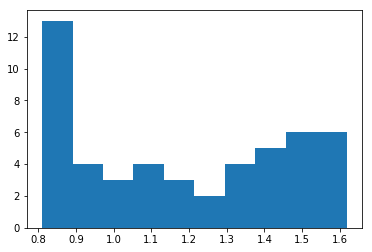

In [30]:
c_ret = np.array(cumulative_return)
c_ret_vec = (c_ret[:, -1]/c_ret[:, 0])

print (f'Mean: {np.mean(c_ret_vec)}; Min: {min(c_ret_vec)}; Max {max(c_ret_vec)}')
plt.hist(c_ret_vec)

#### Test run a sequence

In [31]:
test_config = dict()

start_idx = 50
test_config['price_array'] = price_array[start_idx:]
test_config['tech_array'] = tech_array[start_idx:]

#randomly start day index for back testing
test_config['if_sequence'] = True
# disable random initial capital 
test_config['if_randomV'] = False

test_config['if_value'] = reward_on_value
test_config['lookback_n'] = lookback_n

max_step = min(test_config['price_array'].shape[0]-1, 100)

In [32]:
test_env = CryptoTradingEnv(test_config, \
                            initial_capital=0, \
                            max_step = max_step, \
                           initial_stocks = np.array([20.0]), 
                           reward_scaling = reward_scaling)

#test_model = PPO.load(cwd)
test_model = DDPG.load(cwd)

test_model = test_model.policy.eval()

In [33]:
cumulative_return = testRun(test_model, test_env, run_n = 1)

if test_config['if_value']:
    holding_return = price_array[start_idx + max_step, 1] / price_array[start_idx, 1]
else:
    holding_return = 1.0

print ("Holding-strategy return: ", holding_return)

initial stock: [20.] inital amount:  0
initial asset:  5195.279296875
[Day 2] SELL: 16.0
[Day 3] SELL: 3.2
[Day 4] SELL: 0.64
[Day 5] SELL: 0.1279
[Day 8] BUY: 17.480600000000003
[Day 9] BUY: 3.6592000000000002
[Day 10] BUY: 0.7297
[Day 11] BUY: 0.14830000000000002
[Day 12] BUY: 0.0302
[Day 13] BUY: 0.0059
[Day 14] BUY: 0.0012000000000000001
[Day 20] BUY: 0.0002
[Day 21] BUY: 0.0001
Episode Return:  1.0303234366962704
Holding-strategy return:  0.9329453570311653


Text(0.5, 0, 'time')

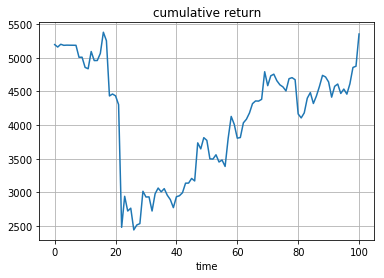

In [34]:
plt.plot(cumulative_return[0], label='agent return')
plt.grid()
plt.title('cumulative return')
plt.xlabel('time')

Text(0.5, 0, 'time')

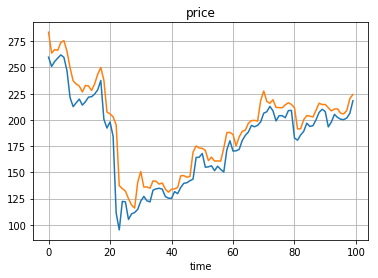

In [35]:
plt.plot(test_config['price_array'][:100, 2:4], label='px')
plt.grid()
plt.title('price')
plt.xlabel('time')